In [10]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import random
import xlrd
from scipy import interpolate
pd.set_option('display.max_columns', 5000)  # or 1000
pd.set_option('display.max_rows', 5000)  # or 1000
import time
from numpy import concatenate
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error, r2_score

# Load observation data and find the bloom events

In [128]:
# Make sure you are in the main folder('..\Algal-bloom-prediction-machine-learning')
cd = os.getcwd()
while cd.split('\\')[-1]!='Algal-bloom-prediction-machine-learning':
    os.chdir('..')
    cd=os.getcwd()
trainning_folder = 'Trainning data'
# Load observation data
os.chdir(trainning_folder)
lakename = input('Lake name in short(e.g., ME, LV):')
df = pd.read_csv(lakename+'_Observation_df_nowinter.csv',sep = '\t',parse_dates = ['Date'])
print(df.columns)
Chl_name=input('Name of Chl variable: ')
OB = df[['Date',Chl_name]].drop_duplicates(subset='Date')

Lake name in short(e.g., ME, LV):Mueggelsee
Index(['Date', 'thermD', 'delT', 'U', 'AirP', 'Hum', 'AirT', 'SWR', 'CC',
       'Prec', 'Ice_d', 'days from iceoff date', 'MM', 'MLD', 'W', 'SRP',
       'TotP', 'NH4', 'NO3', 'Si', 'Chl'],
      dtype='object')
Name of Chl variable: Chl


In [110]:
# Interpolate daily data
sdate = OB['Date'].iloc[0]
edate = OB['Date'].iloc[-1]
OB_int = OB.set_index('Date').reindex(pd.date_range(start = sdate,end = edate,freq = '1D')).interpolate(method = 'linear',limit=20)
#OB_int.fillna(method = 'bfill',inplace = True)
OB_int = OB_int.reset_index()
OB_int.columns = ['Date',Chl_name]
#OB_int['Chl (mg/m3)'] = OB_int['Chl (mg/m3)'].rolling(7,min_periods = 1).mean()
OB_int['Date'] = OB_int['Date'].apply(lambda d:d.date())

Threshold of delta_Chl:2
Threshold of Chl:10


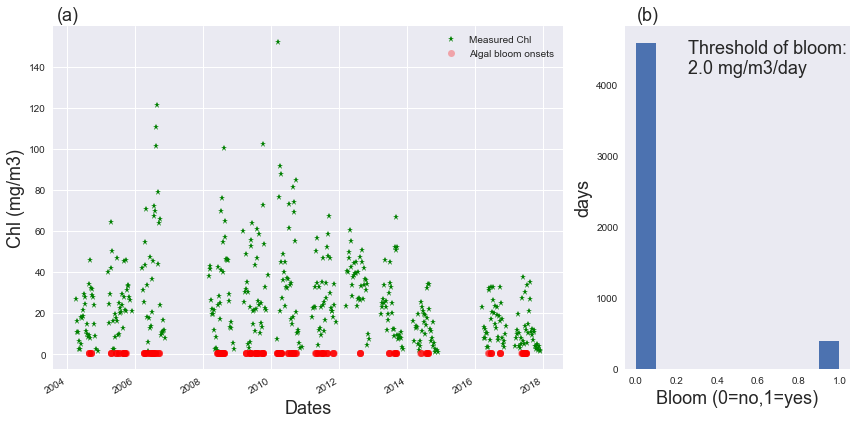

In [111]:
# Use the delta_Chl threshold to find the onset dates of algal bloom
threshold1 = float(input('Threshold of delta_Chl:'))
threshold2 = float(input('Threshold of Chl:'))
def find_bloom(x):
    if (x['delta_Chl']>threshold1)&(x[Chl_name]>threshold2): #(x[Chl_name]>threshold2)
        return 1
    else:
        return 0

OB_int['delta_Chl'] = np.diff(OB_int[Chl_name],append=0)
OB_int['Bloom'] = OB_int.apply(lambda x: find_bloom(x), axis=1) 
OB_int['Date'] = pd.to_datetime(OB_int['Date'])
OB_bloom = OB_int[['Date','Bloom']]

fig=plt.figure(tight_layout='pad',figsize = (12,6))
plt.style.use('seaborn')
gs = fig.add_gridspec(1, 3)
ax1 = fig.add_subplot(gs[0, :-1])
ax2 = fig.add_subplot(gs[0, -1])
OB_bloom['Bloom'].hist(grid=False,ax=ax2)
OB.plot(x = 'Date',y = Chl_name,style = 'g*',ax=ax1,label='Measured Chl')
#OB_int.plot(x = 'Date',y = Chl_name,style = 'g-',ax=ax1,label='Interpolated Measured Chl')
ax1.plot(OB_bloom[OB_bloom['Bloom']==1]['Date'],
         OB_bloom[OB_bloom['Bloom']==1]['Bloom']*0.5,'ro',alpha=0.3,label='Algal bloom onsets')
ax1.legend(loc=0,frameon=False)
ax1.set_xlabel('Dates',fontsize=18)
ax1.set_ylabel('Chl (mg/m3)',fontsize=18)
#ax1.set_xlim(pd.Timestamp(2017,3,1),pd.Timestamp(2020,11,1))
ax1.set_title('(a)',x=0.03,fontsize=18)
ax2.set_xlabel('Bloom (0=no,1=yes)',fontsize=18)
ax2.set_ylabel('days',fontsize=18)
ax2.set_title('(b)',x=0.1,fontsize=18)
fig.text(0.8,0.9,'Threshold of bloom: \n'+str(threshold1)+' mg/m3/day',fontsize=18,
         horizontalalignment='left',
         verticalalignment='top')
fig.savefig(lakename+'_Chl observation and bloom dates.png',dpi=300)

In [112]:
OB['YY']=OB['Date'].apply(lambda d:d.year)
yy=OB['YY'].unique()
sam_int=[]
for i in range(len(yy)):
    sam_int.append(OB[OB['YY']==yy[i]]['Date'].diff().mean().days)
print('Averaged sample interval: {}'.format(round(np.nanmean(sam_int))))

Averaged sample interval: 7


In [129]:
sample_interval=int(input('Sample interval: '))
rolling_interval=int(input('Rolling interval: '))
rolling_threshold=float(input('Rolling bloom threshold: '))

# GBR model
# Make sure you are in the main folder('..\Algal-bloom-prediction-machine-learning')
cd = os.getcwd()
while cd.split('\\')[-1]!='Algal-bloom-prediction-machine-learning':
    os.chdir('..')
    cd=os.getcwd()
os.chdir('Scenario2\\GBR\\'+lakename)

Erken_Nut = pd.read_csv(lakename+'_GBR predicted nutrient and Chl.csv',sep = ',',
                        parse_dates=['Date'])
GBR_Chl = Erken_Nut[['Date',Chl_name]]
GBR_Chl[Chl_name] = GBR_Chl[Chl_name].rolling(sample_interval,center=True,closed='both',
                                              min_periods = 1).mean() # Get 7-day rolling mean of Ch
ts=pd.DataFrame(pd.date_range(start=GBR_Chl['Date'].iloc[0],
                              end=GBR_Chl['Date'].iloc[-1],
                              freq='D'),
                columns=['Date'])
GBR_Chl=ts.merge(GBR_Chl,on='Date',how='left')
GBR_Chl['delta_Chl'] = np.diff(GBR_Chl[Chl_name],append = 0)
GBR_Chl['Bloom'] = GBR_Chl.apply(lambda x: find_bloom(x),axis=1)
GBR_bloom = GBR_Chl[['Date','Bloom']]
GBR_bloom['rolling_bloom']=GBR_bloom['Bloom'].rolling(rolling_interval,
                                                      center=True,
                                                      closed='both').mean().apply(lambda x: 1 if x>=rolling_threshold else 0)

# Find the model hits the events or not
Event_detection = OB_bloom.merge(GBR_bloom[['Date','rolling_bloom']],how = 'inner',on = 'Date')
Event_detection.columns = ['Date','OB','GBR']

# LSTM model
cd = os.getcwd()
while cd.split('\\')[-1]!='Algal-bloom-prediction-machine-learning':
    os.chdir('..')
    cd=os.getcwd()
os.chdir('Scenario2\\LSTM\\'+lakename)

Erken_Nut = pd.read_csv(lakename+'_LSTM predicted nutrient and Chl data.csv',sep = '\t',
                       parse_dates=['Date'])
LSTM_Chl = Erken_Nut[['Date',Chl_name]]
LSTM_Chl[Chl_name] = LSTM_Chl[Chl_name].rolling(sample_interval,center=True,closed='both',
                                                min_periods = 1).mean() # Get 7-day rolling mean of Ch
ts=pd.DataFrame(pd.date_range(start=LSTM_Chl['Date'].iloc[0],
                              end=LSTM_Chl['Date'].iloc[-1],
                              freq='D'),
                columns=['Date'])
LSTM_Chl=ts.merge(LSTM_Chl,on='Date',how='left')
LSTM_Chl['delta_Chl'] = np.diff(LSTM_Chl[Chl_name],append = 0)
LSTM_Chl['Bloom'] = LSTM_Chl.apply(lambda x: find_bloom(x),axis=1)
LSTM_bloom = LSTM_Chl[['Date','Bloom']]
LSTM_bloom['rolling_bloom']=LSTM_bloom['Bloom'].rolling(rolling_interval,
                                                        center=True,
                                                        closed='both').mean().apply(lambda x: 1 if x>=rolling_threshold else 0)

# Find the model hits the events or not
Event_detection = Event_detection.merge(LSTM_bloom[['Date','rolling_bloom']],how = 'inner',on = 'Date')
Event_detection.columns = ['Date','OB','GBR','LSTM']

# Compute the metrics
tn, fp, fn, tp=confusion_matrix(Event_detection['OB'],Event_detection['GBR']).ravel() 
(tn, fp, fn, tp)
TPR=tp/(tp+fn)
FPR=fp/(fp+tn)
accuracy=(tn+tp)/(tn+tp+fn+fp)
precision=tp/(tp+fp)
prevalence=(fn+tp)/(tn+tp+fn+fp)
f1=tp/(tp+0.5*(fp+fn))
pe=((tp+fp)/(tn+tp+fn+fp)*(fn+tn)/(tn+tp+fn+fp))+((tp+fn)/(tn+tp+fn+fp)*(fp+tn)/(tn+tp+fn+fp))
kappa=(accuracy-pe)/(1-pe)

print('GBR model')
print('TPR: {},\nFPR: {}, \naccuracy: {}, \nprecision: {}, \nprevalence: {},\nf1: {}, \nkappa:{}.'.format(round(TPR,2),
                                                                                                          round(FPR,2),
                                                                                                          round(accuracy,2),
                                                                                                          round(precision,2),
                                                                                                          round(prevalence,2),
                                                                                                          round(f1,2),
                                                                                                          round(kappa,2)))

metrics=pd.DataFrame({'TPR':[TPR],'FPR':[FPR],'Accuracy': [accuracy],'Precision':[precision],
             'prevalence':[prevalence],'F1':[f1],'Kappa':[kappa]},index=['GBR'])

tn, fp, fn, tp=confusion_matrix(Event_detection['OB'],Event_detection['LSTM']).ravel() 
(tn, fp, fn, tp)
TPR=tp/(tp+fn)
FPR=fp/(fp+tn)
accuracy=(tn+tp)/(tn+tp+fn+fp)
precision=tp/(tp+fp)
prevalence=(fn+tp)/(tn+tp+fn+fp)
f1=tp/(tp+0.5*(fp+fn))
pe=((tp+fp)/(tn+tp+fn+fp)*(fn+tn)/(tn+tp+fn+fp))+((tp+fn)/(tn+tp+fn+fp)*(fp+tn)/(tn+tp+fn+fp))
kappa=(accuracy-pe)/(1-pe)

print('\n')
print('LSTM model ')
print('TPR: {},\nFPR: {}, \naccuracy: {}, \nprecision: {}, \nprevalence: {},\nf1: {}, \nkappa:{}.'.format(round(TPR,2),
                                                                                                          round(FPR,2),
                                                                                                          round(accuracy,2),
                                                                                                          round(precision,2),
                                                                                                          round(prevalence,2),
                                                                                                          round(f1,2),
                                                                                                          round(kappa,2)))
metrics=metrics.append(pd.DataFrame({'TPR':[TPR],'FPR':[FPR],'Accuracy': [accuracy],'Precision':[precision],
             'prevalence':[prevalence],'F1':[f1],'Kappa':[kappa]},index=['LSTM']))

Sample interval: 7
Rolling interval: 3
Rolling bloom threshold: 0.01
GBR model
TPR: 0.0,
FPR: 0.0, 
accuracy: 0.95, 
precision: nan, 
prevalence: 0.05,
f1: 0.0, 
kappa:0.95.


LSTM model 
TPR: 0.02,
FPR: 0.03, 
accuracy: 0.93, 
precision: 0.04, 
prevalence: 0.05,
f1: 0.03, 
kappa:0.92.


C:\Users\shuli278\AppData\Local\Temp/ipykernel_10040/925510593.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GBR_Chl[Chl_name] = GBR_Chl[Chl_name].rolling(sample_interval,center=True,closed='both',
C:\Users\shuli278\AppData\Local\Temp/ipykernel_10040/925510593.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GBR_bloom['rolling_bloom']=GBR_bloom['Bloom'].rolling(rolling_interval,
C:\Users\shuli278\AppData\Local\Temp/ipykernel_10040/925510593.py:44: SettingWithCopyWarning: 
A value is trying to be 

Text(0, 0.5, '%')

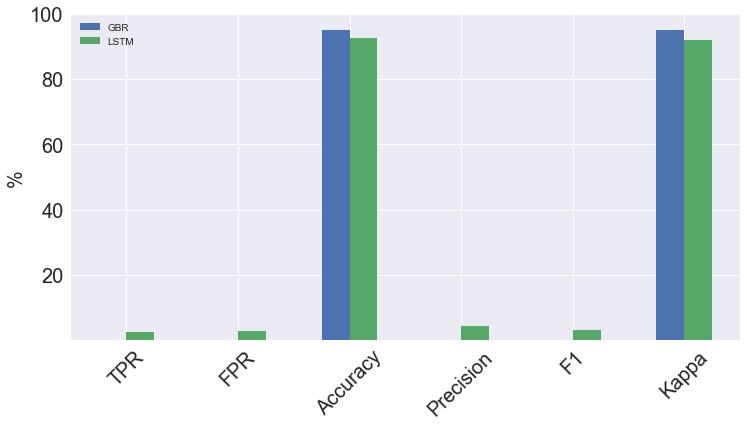

In [130]:
f,ax=plt.subplots(figsize=(12,6))
(metrics[['TPR','FPR','Accuracy','Precision','F1','Kappa']]*100).T.plot(kind='bar',ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,fontsize=20)
ax.set_yticks([20,40,60,80,100])
ax.set_yticklabels([20,40,60,80,100],fontsize=20)
ax.set_ylabel('%',fontsize=20)

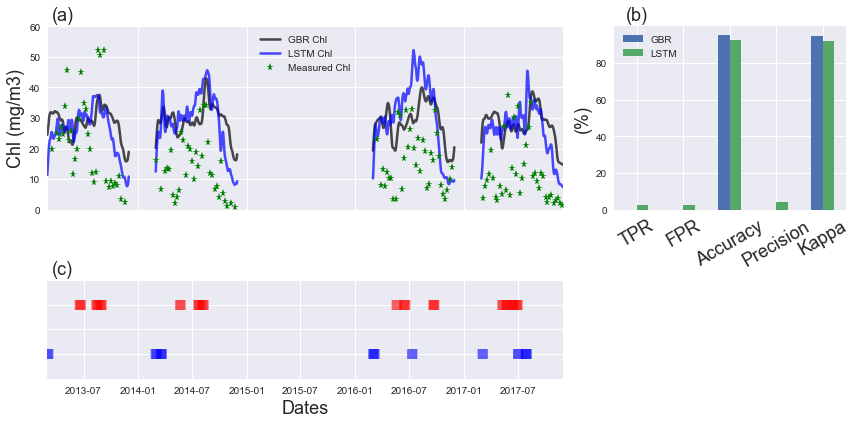

In [131]:
fig=plt.figure(tight_layout='True',figsize = (12,6))
plt.style.use('seaborn')
gs = fig.add_gridspec(5, 3)
ax1 = fig.add_subplot(gs[0:3, :-1])
ax2 = fig.add_subplot(gs[0:3, -1])
ax3 = fig.add_subplot(gs[3:5, :-1])
Date = pd.DataFrame(pd.date_range(start = GBR_Chl['Date'].iloc[0],
                                  end = GBR_Chl['Date'].iloc[-1]),
                    columns = ['Date'])
(metrics[['TPR','FPR','Accuracy','Precision','Kappa']]*100).T.plot(kind='bar',ax=ax2)
#OB_int.plot(x = 'Date',y = Chl_name,style = 'g-',lw=1.5,ax=ax1,label='Interpolated Measured Chl')
GBR_Chl.merge(Date,on='Date',how='outer').plot(x = 'Date',y = Chl_name,
                                               style = 'k-',lw=2.5,alpha=0.7,ax=ax1,label='GBR Chl')
LSTM_Chl.merge(Date,on='Date',how='outer').plot(x = 'Date',y = Chl_name,
                                                style = 'b-',lw=2.5,alpha=0.7,ax=ax1,label='LSTM Chl')
OB.plot(x = 'Date',y = Chl_name,style = 'g*',ms=8,ax=ax1,label='Measured Chl')
ax3.plot(OB_bloom[OB_bloom['Bloom']==1]['Date'],
         OB_bloom[OB_bloom['Bloom']==1]['Bloom']*0.5+0.05,
         'rs',markersize=10,alpha=0.2,label='Algal bloom onsets')
ax3.plot(GBR_bloom[GBR_bloom['rolling_bloom']==1]['Date'],
         GBR_bloom[GBR_bloom['rolling_bloom']==1]['rolling_bloom']*0.5,
         'ks',markersize=10,alpha=0.2,label='GBR Algal bloom onsets')
ax3.plot(LSTM_bloom[LSTM_bloom['rolling_bloom']==1]['Date'],
         LSTM_bloom[LSTM_bloom['rolling_bloom']==1]['rolling_bloom']*0.5-0.05,
         'bs',markersize=10,alpha=0.2,label='LSTM Algal bloom onsets')

ax1.legend(loc=0,frameon=False)
ax1.set_ylabel('Chl (mg/m3)',fontsize=18)
ax1.set_ylim(0,60)
ax1.set_title('(a)',x=0.03,fontsize=18)
ax1.set_xlim(GBR_Chl['Date'].iloc[0],GBR_Chl['Date'].iloc[-1])
ax1.set_xticklabels([])
ax1.set_xlabel('')
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=30,fontsize=18)
ax2.set_ylabel('(%)',fontsize=18)
ax2.set_title('(b)',x=0.1,fontsize=18)
ax3.set_xlim(GBR_Chl['Date'].iloc[0],GBR_Chl['Date'].iloc[-1])
ax3.set_xlabel('Dates',fontsize=18)
ax3.set_ylim(0.4,0.6)
ax3.set_yticklabels([])
ax3.set_title('(c)',x=0.03,fontsize=18)
plt.tight_layout(pad=0.1, w_pad=0.5, h_pad=0.2)
fig.savefig(lakename+'_Chl observation and bloom dates.png',dpi=300)

In [133]:
def metrics(obs_df,model_df,nutrient,date):
    df = obs_df[['Date',nutrient]].merge(model_df[['Date',nutrient]],how = 'inner',on = 'Date')
    df.columns = ['Date','Obs','PM']
    Comp = df[df['Date']>=date].dropna()
    RMSE = mean_squared_error(Comp['Obs'], Comp['PM'],squared=False)
    MAE = mean_absolute_error(Comp['Obs'], Comp['PM'])
    R2 = r2_score(Comp['Obs'], Comp['PM'])
    print(nutrient+' RMSE: %.2f' % RMSE)
    print(nutrient+' MAE: %.2f' % MAE)
    print(nutrient+' R2: %.2f' % R2)
    print('\n')
    return Comp

print('GBR')
comp=metrics(OB,GBR_Chl,Chl_name,pd.Timestamp(2013,1,1))
print('LSTM')
comp=metrics(OB,LSTM_Chl,Chl_name,pd.Timestamp(2013,1,1))

GBR
Chl RMSE: 17.25
Chl MAE: 15.34
Chl R2: -1.01


LSTM
Chl RMSE: 17.36
Chl MAE: 14.95
Chl R2: -1.04




In [95]:
os.getcwd()

'C:\\Users\\shuli278\\Documents\\D\\PDF_Uppsala\\7-Python code of ML algorithm\\GitHub\\Algal-bloom-prediction-machine-learning\\Algal-bloom-prediction-machine-learning\\Scenario2\\LSTM\\ME'